### NLP Classification Project

##### Building a spam filter with the kernel framework. 

Emails are either classed as undersired "spam" or "ham". This classification task is applies and uses variants of edit distance within a kernel framework. LibSVM algorithm is then applied to clasify the data as either "ham" or "spam". The <a href = "https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection">SMS Spam Collection Data Set</a> from UCI machine learning repository 

* Clean the data
* Carry out data exploration
* split, tokenize, remove punctuation
* Extract features
* Construct kernels
* Run classification 
* Compare and analyse

In [1]:
#Import required files
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re
import string
from zipfile import ZipFile 
import requests
from libsvm.svmutil import *
from util_ker import *
from util_ker import EvaluateTest
from util_Text import *
from LogUtil import *
import seaborn as sns
import time

%matplotlib inline
pd.set_option('display.max_colwidth', 100)

### Download Data

In [2]:
#download 'smsspamcollection.zip' files from UCI website (file is a zipped file )
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
r = requests.get(url, allow_redirects=True)
open('smsspamcollection.zip', 'wb').write(r.content)
fname = 'smsspamcollection.zip'

In [3]:
#Extract the zipped file
with ZipFile(fname, 'r') as nip: 
    nip.printdir() 
     
    nip.extractall() 
    print('Extraction Complete!') 

File Name                                             Modified             Size
SMSSpamCollection                              2011-03-15 22:36:02       477907
readme                                         2011-04-18 14:53:56         5868
Extraction Complete!


In [4]:
#Load Data
data = pd.read_csv("./SMSSpamCollection", sep='\t', header=None, names=['label','Text'])

In [5]:
data.head()

,label,Text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


In [6]:
print(f'The data is made up of {data.shape[0]} examples ')

The data is made up of 5572 examples 


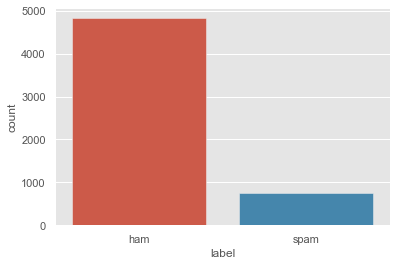

In [7]:
sns.countplot(data.label)
plt.show()

In [8]:
len_ham  = data[data['label']=='ham'].count()[0]
len_spam = data[data['label']=='spam'].count()[0]
print(f'{len_ham} examples classed as ham. {len_spam} examples classed as spam')

4825 examples classed as ham. 747 examples classed as spam


# Uneven Length Sequences

In [9]:
#Extract the length of each example
lenData = np.zeros((len(data),1))
for i in range(len(data)):
    lenData[i] = len(data.Text[i])

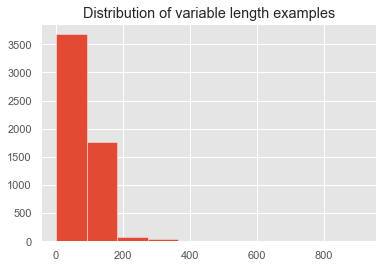

In [10]:
#Plot a histogram showing the distribution of the variable length
plt.hist(lenData);
plt.title('Distribution of variable length examples');

### Clean Data

 - Remove punctuation
 - Tokenize the strings
 - Remove stop words

In [11]:
data['Text_cleaned'] = data['Text'].apply(lambda x: clean_text(x)) #Applies the function to each row
data.head(10)

,label,Text,Text_cleaned
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...","[Go, jurong, point, crazy, Available, bugis, n, great, world, la, e, buffet, Cine, got, amore, wat]"
1,ham,Ok lar... Joking wif u oni...,"[Ok, lar, Joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,"[Free, entry, 2, wkly, comp, win, FA, Cup, final, tkts, 21st, May, 2005, Text, FA, 87121, receiv..."
3,ham,U dun say so early hor... U c already then say...,"[U, dun, say, early, hor, U, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives around here though","[Nah, I, dont, think, goes, usf, lives, around, though]"
5,spam,FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for ...,"[FreeMsg, Hey, darling, 3, weeks, word, back, Id, like, fun, still, Tb, ok, XxX, std, chgs, send..."
6,ham,Even my brother is not like to speak with me. They treat me like aids patent.,"[Even, brother, like, speak, They, treat, like, aids, patent]"
7,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your call...,"[As, per, request, Melle, Melle, Oru, Minnaminunginte, Nurungu, Vettam, set, callertune, Callers..."
8,spam,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To c...,"[WINNER, As, valued, network, customer, selected, receivea, 900, prize, reward, To, claim, call,..."
9,spam,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with came...,"[Had, mobile, 11, months, U, R, entitled, Update, latest, colour, mobiles, camera, Free, Call, T..."


### Apply Stemming

In [12]:
# ['Porter','Lancaster']
Stemmer = 'Porter'

In [13]:
data['Text_stemmed'] = data['Text_cleaned'].apply(lambda x: stemming(x,Stemmer))
data.head()

,label,Text,Text_cleaned,Text_stemmed
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...","[Go, jurong, point, crazy, Available, bugis, n, great, world, la, e, buffet, Cine, got, amore, wat]","[Go, jurong, point, crazi, avail, bugi, n, great, world, la, e, buffet, cine, got, amor, wat]"
1,ham,Ok lar... Joking wif u oni...,"[Ok, lar, Joking, wif, u, oni]","[Ok, lar, joke, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,"[Free, entry, 2, wkly, comp, win, FA, Cup, final, tkts, 21st, May, 2005, Text, FA, 87121, receiv...","[free, entri, 2, wkli, comp, win, FA, cup, final, tkt, 21st, may, 2005, text, FA, 87121, receiv,..."
3,ham,U dun say so early hor... U c already then say...,"[U, dun, say, early, hor, U, c, already, say]","[U, dun, say, earli, hor, U, c, alreadi, say]"
4,ham,"Nah I don't think he goes to usf, he lives around here though","[Nah, I, dont, think, goes, usf, lives, around, though]","[nah, I, dont, think, goe, usf, live, around, though]"


### Lemmatize the data

In [14]:
data['Text_lemmatized'] = data['Text_stemmed'].apply(lambda x: lemmatizing(x))

data.head()

,label,Text,Text_cleaned,Text_stemmed,Text_lemmatized
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...","[Go, jurong, point, crazy, Available, bugis, n, great, world, la, e, buffet, Cine, got, amore, wat]","[Go, jurong, point, crazi, avail, bugi, n, great, world, la, e, buffet, cine, got, amor, wat]","[Go, jurong, point, crazi, avail, bugi, n, great, world, la, e, buffet, cine, got, amor, wat]"
1,ham,Ok lar... Joking wif u oni...,"[Ok, lar, Joking, wif, u, oni]","[Ok, lar, joke, wif, u, oni]","[Ok, lar, joke, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,"[Free, entry, 2, wkly, comp, win, FA, Cup, final, tkts, 21st, May, 2005, Text, FA, 87121, receiv...","[free, entri, 2, wkli, comp, win, FA, cup, final, tkt, 21st, may, 2005, text, FA, 87121, receiv,...","[free, entri, 2, wkli, comp, win, FA, cup, final, tkt, 21st, may, 2005, text, FA, 87121, receiv,..."
3,ham,U dun say so early hor... U c already then say...,"[U, dun, say, early, hor, U, c, already, say]","[U, dun, say, earli, hor, U, c, alreadi, say]","[U, dun, say, earli, hor, U, c, alreadi, say]"
4,ham,"Nah I don't think he goes to usf, he lives around here though","[Nah, I, dont, think, goes, usf, lives, around, though]","[nah, I, dont, think, goe, usf, live, around, though]","[nah, I, dont, think, goe, usf, live, around, though]"


### Change labels from ham to -1 and spam to 1

In [15]:
data.replace({'label': {'ham': 0, 'spam': 1}}, inplace=True)

In [16]:
data.tail()

,label,Text,Text_cleaned,Text_stemmed,Text_lemmatized
5567,1,This is the 2nd time we have tried 2 contact u. U have won the £750 Pound prize. 2 claim is easy...,"[This, 2nd, time, tried, 2, contact, u, U, 750, Pound, prize, 2, claim, easy, call, 087187272008...","[thi, 2nd, time, tri, 2, contact, u, U, 750, pound, prize, 2, claim, easi, call, 087187272008, n...","[thi, 2nd, time, tri, 2, contact, u, U, 750, pound, prize, 2, claim, easi, call, 087187272008, n..."
5568,0,Will ü b going to esplanade fr home?,"[Will, ü, b, going, esplanade, fr, home]","[will, ü, b, go, esplanad, fr, home]","[will, ü, b, go, esplanad, fr, home]"
5569,0,"Pity, * was in mood for that. So...any other suggestions?","[Pity, mood, Soany, suggestions]","[piti, mood, soani, suggest]","[piti, mood, soani, suggest]"
5570,0,The guy did some bitching but I acted like i'd be interested in buying something else next week ...,"[The, guy, bitching, I, acted, like, id, interested, buying, something, else, next, week, gave, ...","[the, guy, bitch, I, act, like, id, interest, buy, someth, els, next, week, gave, us, free]","[the, guy, bitch, I, act, like, id, interest, buy, someth, el, next, week, gave, u, free]"
5571,0,Rofl. Its true to its name,"[Rofl, Its, true, name]","[rofl, it, true, name]","[rofl, it, true, name]"


In [17]:
sample=78 #Change to view sample data

print('\033[92m')
print(data.Text[sample])
print('\033[90m'+ 'Raw_Text')

print('\033[94m')
print(data.Text_cleaned[sample])
print('\033[90m'+ 'Cleaned to tokenize, remove punctuation and stopwords')

print('\033[96m')
print(data.Text_stemmed[sample])
print('\033[90m'+ 'Stemmed with Porter stemmer')

print('\033[91m')
print(data.Text_lemmatized[sample])
print('\033[90m'+ 'Lemmatized with WordNetLemmatizer')


Does not operate after  &lt;#&gt;  or what
Raw_Text

['Does', 'operate', 'ltgt']
Cleaned to tokenize, remove punctuation and stopwords

['doe', 'oper', 'ltgt']
Stemmed with Porter stemmer

['doe', 'oper', 'ltgt']
Lemmatized with WordNetLemmatizer


### Extract predictor variables and target label

In [18]:
Y = data.label.values.reshape(len(data),1)
X = data.Text_stemmed.values.reshape(len(Y),1)  #data.iloc[:,4].values.shape

In [81]:
# Split data into Training, Test and Validation data sets
xtr, xva, xte, ytr, yva, yte = splitdata(X, Y, 15, 0.8)

4458 training examples and 1 features
557 validation examples and 1 features
557 testing examples and 1 features


In [84]:
xva

array([[list(['hi', 'babi', 'im', 'cruisin', 'girl', 'friend', 'r', 'u', '2', 'give', 'call', 'hour', 'home', 'that', 'alright', 'fone', 'fone', 'love', 'jenni', 'xxx'])],
       [list(['aight', 'time', 'want', 'come'])],
       [list(['congratul', 'ur', 'award', 'either', 'yr', 'suppli', 'cd', 'virgin', 'record', 'mysteri', 'gift', 'guarante', 'call', '09061104283', 'tsc', 'wwwsmsconet', '150pm', 'approx', '3min'])],
       [list(['Er', 'mw', 'im', 'fill', 'tuth', 'aight'])],
       [list(['88066', 'from', '88066', 'lost', '3pound', 'help'])],
       [list(['I', 'actual', 'first', 'time', 'I', 'went', 'bed', 'long', 'spoke', 'woke', '7', 'how', 'night'])],
       [list(['hui', 'xin', 'da', 'lib'])],
       [list(['ive', 'reach', 'sch', 'alreadi'])],
       [list(['I', 'dont', 'know', 'u', 'u', 'dont', 'know', 'send', 'chat', '86688', 'let', 'find', 'onli', '150pmsg', 'rcvd', 'hgsuite3422landsroww1j6hl', 'ldn', '18', 'year'])],
       [list(['free', 'entri', '250', 'weekli', 'competit'

In [85]:
num_of_train_pos = ytr[ytr==1].sum()
num_of_val_pos   = yva[yva==1].sum()
num_of_test_pos  = yte[yte==1].sum()
num_of_train_neg = len(ytr) -  ytr[ytr==1].sum()
num_of_val_neg   = len(yva) -  yva[yva==1].sum()
num_of_test_neg  = len(yte) -  yte[yte==1].sum()

In [86]:
print("Training set has {} positive and {} negative labels".format(num_of_train_pos ,num_of_train_neg))
print("Validation set has {} positive and {} negative labels".format(num_of_val_pos,num_of_val_neg))
print("Test set has {} positive and {} negative labels".format(num_of_test_pos,num_of_test_neg))

Training set has 594 positive and 3864 negative labels
Validation set has 79 positive and 478 negative labels
Test set has 74 positive and 483 negative labels


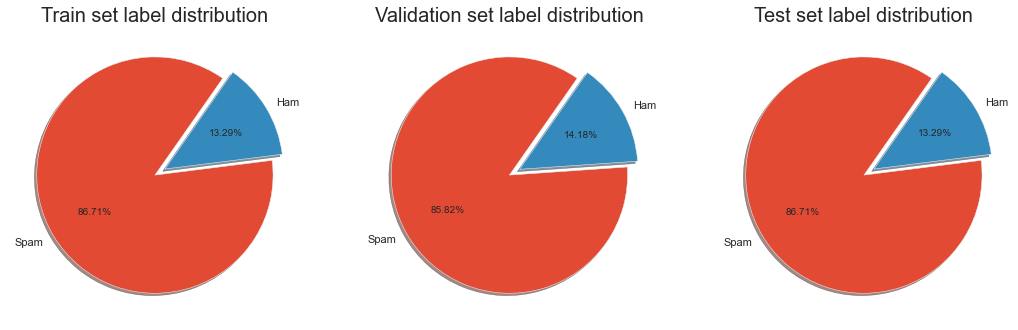

In [87]:
# Initialize the plot
YTR = pd.DataFrame(ytr)
YTE = pd.DataFrame(yte)
YVE = pd.DataFrame(yva)

fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

Labels = ['Spam', 'Ham']
Explode = [0,0.1]

ax1.pie(YTE.value_counts().values, explode=Explode, labels=Labels,shadow=True,startangle=55,autopct='%1.2f%%');
ax1.set_title('Train set label distribution',fontsize=20);

ax2.pie(YVE.value_counts().values, explode=Explode, labels=Labels ,shadow=True,startangle=55,autopct='%1.2f%%');
ax2.set_title('Validation set label distribution',fontsize=20);

ax3.pie(YTE.value_counts().values, explode=Explode, labels=Labels, shadow=True,startangle=55,autopct='%1.2f%%');
ax3.set_title('Test set label distribution',fontsize=20);

## Build Probabilistic Model

In [88]:
pos_index = np.where(Y==1)
neg_index = np.where(Y==-1)

In [89]:
def build_freq(examples, label):
    label_list = np.squeeze(label).tolist() #Converts the label to list
    freq={}
    
    for lab, Text in zip(label_list, examples):
        for word in Text[0]:  
            pair = (word, lab)
            #freq[pair] = freq.get(pair,0)
            if pair in freq:
                freq[pair] += 1
            else:
                freq[pair] = 1
    return freq

In [90]:
data_freq = build_freq(xtr, ytr)

In [91]:
print(data_freq)

{('Ü', 0): 39, ('go', 0): 320, ('home', 0): 133, ('liao', 0): 26, ('ask', 0): 107, ('dad', 0): 25, ('pick', 0): 67, ('6', 0): 23, ('freemsg', 1): 10, ('whi', 1): 6, ('havent', 1): 1, ('repli', 1): 86, ('text', 1): 115, ('Im', 1): 12, ('randi', 1): 2, ('sexi', 1): 12, ('femal', 1): 1, ('live', 1): 24, ('local', 1): 3, ('luv', 1): 5, ('hear', 1): 3, ('u', 1): 51, ('netcollex', 1): 4, ('ltd', 1): 13, ('08700621170150p', 1): 2, ('per', 1): 43, ('msg', 1): 30, ('stop', 1): 96, ('end', 1): 20, ('cool', 0): 30, ('tyler', 0): 4, ('take', 0): 111, ('gonna', 0): 50, ('buy', 0): 60, ('drop', 0): 21, ('place', 0): 44, ('later', 0): 111, ('tonight', 0): 46, ('our', 0): 9, ('total', 0): 6, ('order', 0): 6, ('quarter', 0): 1, ('got', 0): 187, ('enough', 0): 23, ('I', 0): 1149, ('wait', 0): 71, ('4', 0): 129, ('ü', 0): 91, ('insid', 0): 6, ('da', 0): 98, ('car', 0): 36, ('park', 0): 15, ('It', 0): 57, ('happen', 0): 38, ('r', 0): 84, ('2waxsto', 0): 2, ('wat', 0): 84, ('want', 0): 166, ('she', 0): 54,

In [92]:
len(data_freq)

8255

# Train Model with Naive Bayes 

In [93]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of tweets
        train_y: a list of labels correponding to the tweets (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0

    # calculate V, the number of unique words in the vocabulary
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)
    
    # calculate N_pos and N_neg
    N_pos = N_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:

            # Increment the number of positive words by the count for this (word, label) pair
            N_pos += freqs.get(pair,0)
            
        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            N_neg += freqs.get(pair,0)
                
    # Calculate D, the number of documents
    D = len(train_x)
    
    # Calculate D_pos, the number of positive documents (*hint: use sum(<np_array>))
    D_pos = sum(train_y)
   
    # Calculate D_neg, the number of negative documents (*hint: compute using D and D_pos)
    D_neg = D - D_pos
    
    # Calculate logprior
    logprior = np.log(D_pos) - np.log(D_neg)
    
    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = freqs.get((word,1),0)
        freq_neg = freqs.get((word,0),0)
        
        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1)/(N_pos + V)
        p_w_neg = (freq_neg + 1)/(N_neg + V)
        
        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)
        
        
    ### END CODE HERE ###

    return logprior, loglikelihood

In [94]:
logprior, loglikelihood = train_naive_bayes(data_freq, xtr, ytr)

In [95]:
logprior

array([-1.87257888])

In [96]:
loglikelihood

{'': -1.3959591062455126,
 'rodger': 1.573627887204156,
 'claypot': 0.18733352608426543,
 'unbeliev': -0.21813158202389896,
 'resolv': 0.18733352608426543,
 'IM': -2.1640417310792124,
 'remind': 0.03318284625700708,
 'nt': -1.4221043863498348,
 'jet': 0.18733352608426543,
 'inforingtonekingcouk': 1.573627887204156,
 'trade': 0.18733352608426543,
 'iouri': -0.21813158202389896,
 'rington': 4.015974922573361,
 '6day': 1.9790929953123204,
 'wall': -0.7289572057898895,
 'nobut': 0.18733352608426543,
 'YM': -0.21813158202389896,
 'nydc': -0.21813158202389896,
 'romant': -0.21813158202389896,
 'cutefrnd': -0.21813158202389896,
 'rechargerakhesh': 0.18733352608426543,
 'keri': 0.18733352608426543,
 'box385': 1.573627887204156,
 'lik': -0.7289572057898895,
 'girli': 0.18733352608426543,
 'craigslist': 0.18733352608426543,
 'wondar': 0.18733352608426543,
 '4press': 0.18733352608426543,
 'smith': 0.18733352608426543,
 'convinc': -0.7289572057898895,
 'mathemat': 0.18733352608426543,
 'ls278bb': 

In [97]:
def naive_bayes_predict(tweet, logprior, loglikelihood):
    '''
    Input:
        tweet: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Output:
        p: the sum of all the logliklihoods of each word in the tweet (if found in the dictionary) + logprior (a number)

    '''
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # process the tweet to get a list of words
    #word_l = process_tweet(tweet)
   
    # initialize probability to zero
    p = 0

    # add the logprior
    p += logprior
    
    for word in tweet:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            
            # add the log likelihood of that word to the probability
            p += loglikelihood[word]
            
    ### END CODE HERE ###

    return p


In [127]:
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of tweets
        test_y: the corresponding labels for the list of tweets
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of tweets classified correctly)/(total # of tweets)
    """
    accuracy = 0  # return this properly

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    y_hats = []
    for tweet in test_x:
        print(tweet[0])
        #print(naive_bayes_predict(tweet, logprior, loglikelihood))
        # if the prediction is > 0
        if naive_bayes_predict(tweet[0], logprior, loglikelihood) > 0:
            
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error =  1/test_y.shape[0] * sum(np.abs(np.asarray(y_hats) - test_y))

    # Accuracy is 1 minus the error
    accuracy = 1 - error

    ### END CODE HERE ###

    return accuracy

In [128]:
xte[4][0]

['Am',
 'work',
 'eye',
 'philosophi',
 'text',
 'u',
 'later',
 'bit',
 'free',
 'chat']

In [129]:
acc = test_naive_bayes(xte, yte, logprior, loglikelihood)

['hey', 'pple700', '900', '5', 'nightsexcel', 'locat', 'wif', 'breakfast', 'hamper']
['now', 'project', 'pa', 'after', 'come']
['ive', 'bar', 'B', 'Q', 'store', 'lifethi', 'twat', 'orang', 'dungere', 'came', 'ask', 'I', 'want', 'deck', 'So', 'I', 'got', 'first', 'punch']
['haha', 'I', 'thinkin']
['Am', 'work', 'eye', 'philosophi', 'text', 'u', 'later', 'bit', 'free', 'chat']
['Ok', 'da', 'alreadi', 'plan', 'I', 'wil', 'pick']
['On', 'way', 'offic', 'da']
['night', 'night', 'see', 'tomorrow']
['It', 'reassur', 'crazi', 'world']
['dont', 'hesit', 'you', 'know', 'second', 'time', 'weak', 'like', 'So', 'keep', 'notebook', 'eat', 'day', 'anyth', 'chang', 'day', 'sure', 'noth']
['not', 'yet', 'chikkugo', 'room', 'nw', 'im', 'bu']
['where', 'you', 'said', 'would', 'I', 'woke', '']
['whi', 'noth', 'Ok', 'anyway', 'give', 'treat']
['where', 'what', 'how', 'stand', 'away', 'doesnt', 'heart', 'ach', 'without', 'dont', 'wonder', 'dont', 'crave', '']
['Hi', '2night', 'ur', 'lucki', 'night', 'uve', 

In [130]:
acc

array([0.86714542, 0.86714542, 0.86714542, 0.86714542, 0.86714542,
       0.86714542, 0.86714542, 0.86714542, 0.86714542, 0.86714542,
       0.86714542, 0.86714542, 0.86714542, 0.86714542, 0.13285458,
       0.13285458, 0.86714542, 0.86714542, 0.13285458, 0.86714542,
       0.86714542, 0.86714542, 0.86714542, 0.86714542, 0.86714542,
       0.86714542, 0.86714542, 0.86714542, 0.86714542, 0.13285458,
       0.86714542, 0.86714542, 0.86714542, 0.13285458, 0.86714542,
       0.13285458, 0.86714542, 0.86714542, 0.86714542, 0.86714542,
       0.86714542, 0.13285458, 0.86714542, 0.86714542, 0.86714542,
       0.86714542, 0.86714542, 0.86714542, 0.86714542, 0.86714542,
       0.86714542, 0.86714542, 0.86714542, 0.86714542, 0.86714542,
       0.86714542, 0.86714542, 0.86714542, 0.86714542, 0.13285458,
       0.86714542, 0.86714542, 0.13285458, 0.13285458, 0.86714542,
       0.13285458, 0.86714542, 0.86714542, 0.13285458, 0.86714542,
       0.86714542, 0.86714542, 0.86714542, 0.86714542, 0.13285

In [131]:
yte

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
    

In [148]:
yte.shape

(557, 1)